In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import os
from dotmap import DotMap
from tqdm import tqdm
from PIL import Image, ImageOps
from torchvision import transforms

sys.path.append("/home/warburg/repo/bayesian-metric-learning/src")

from datasets.cub200 import TestDataset
from models import configure_model
from lightning.deterministic_model import DeterministicModel
from evaluate.ranking import compute_rank
from evaluate.evaluate import evaluate
from evaluate.utils import get_pos_idx, get_pos_idx_place_recognition, remove_duplicates

In [2]:
args = {"dataset": "cub200", 
        #"resume_posthoc": "../lightning_logs/cub200/laplace_posthoc/1/contrastive/full/checkpoints/best.ckpt",
        "resume": "../lightning_logs/cub200/deterministic",
        "data_dir": "/home/warburg/data",        
        "arch": "resnet50", 
        "pool": "gem",
        "model": "laplace_posthoc",
        "whitening": True, 
        "pretrained": True, 
        "dropout_rate": 0.0, 
        "latent_dim": 512}
args = DotMap(args)

In [3]:
model = DeterministicModel(args, ".", 1)

>> Using pre-trained model 'resnet50'


/home/warburg/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/warburg/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==> test n_samples:  100


In [4]:
statedict = torch.load(args.resume + "/1/checkpoints/best.ckpt")
model.load_state_dict(statedict["state_dict"])
model.eval()
model = model.cuda()


In [5]:
data = TestDataset(args.data_dir)
dataloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=False)

In [6]:
outputs = []
for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    with torch.no_grad():
        o = model(batch[0].cuda())
    o = {k : v.cpu() for k, v in o.items()}
    o["label"] = batch[1]
    outputs.append(o)


100%|██████████| 93/93 [01:00<00:00,  1.53it/s]


In [7]:
def format_outputs(outputs, place_rec=False):

    z_mu = torch.cat([o["z_mu"] for o in outputs])
    if not place_rec:
        targets = torch.cat([o["label"] for o in outputs])
        pidxs = get_pos_idx(targets)
        z_muQ = z_mu
        z_muDb = None
    else:

        index = torch.cat([o["index"] for o in outputs], dim=1)
        utm = torch.cat([o["utm"] for o in outputs])

        queries = index[1, :] == -1
        database = ~queries

        z_muQ = z_mu[queries]
        z_muDb = z_mu[database]
        utmQ = utm[queries]
        utmDb = utm[database]
        idxQ = index[0, :][queries]
        idxDb = index[1, :][database]
        z_muQ, z_muDb, utmQ, utmDb = remove_duplicates(
            z_muQ, z_muDb, utmQ, utmDb, idxQ, idxDb
        )

        pidxs = get_pos_idx_place_recognition(utmQ, utmDb, 25)

    if z_muDb is not None and len(z_muDb) == 0:
        return

    o = {"z_muQ": z_muQ, "z_muDb": z_muDb, "pidxs": pidxs}
    if not place_rec:
        o["targets"] = targets

    if "z_sigma" in outputs[0]:
        z_sigma = torch.cat([o["z_sigma"] for o in outputs])
        if z_muDb is None:
            # merge dicts
            o = {**o, **{"z_sigmaQ": z_sigma, "z_sigmaDb": None}}

    if "z_samples" in outputs[0]:
        z_samples = torch.cat([o["z_samples"] for o in outputs])
        if z_muDb is None:
            # merge dicts
            o = {**o, **{"z_samplesQ": z_samples, "z_samplesDb": None}}

    return o

In [8]:
outputs = format_outputs(outputs, place_rec=args.datasets == "msls")

In [9]:
def compute_distances(embed, ref_embed):

    if ref_embed is None:
        same_source = True
        ref_embed = embed
    else:
        same_source = False

    dist = embed @ ref_embed.T
    dist = torch.sort(-dist, dim=1)[0]
    return dist

dist = compute_distances(outputs["z_muQ"], outputs["z_muDb"])

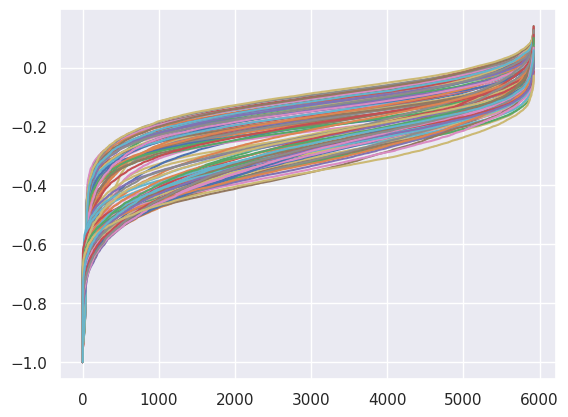

In [10]:
for i in range(100):
    plt.plot(dist[i])
plt.show()

In [11]:

ranks = compute_rank(outputs["z_muQ"], ref_embed=outputs["z_muDb"])
evaluate(ranks, outputs["pidxs"])


{'map': [0.4868039612874184, 0.42210692582232084, 0.3531743472644904],
 'recall': [0.6164753544902093,
  0.8431802835921675,
  0.9073261309925725,
  0.9473328831870358]}

In [12]:
# pick a query
qidx = 1
qclass = data.labels[qidx]

# pick the closest positive
pred = data.labels[ranks[qidx, :]]
prank = np.where(pred == qclass)
closest_p = ranks[qidx, prank[0][0]]
closest_p_dist = dist[qidx, prank[0][0]]

# pick the furthest away positive
furthest_p = ranks[qidx, prank[0][-1]]
furthest_p_dist = dist[qidx, prank[0][-1]]

# pick the closest negative
nrank = np.where(~np.in1d(np.arange(len(ranks[qidx,:])), prank[0]))
closest_n = ranks[qidx, nrank[0][0]]
closest_n_dist = dist[qidx, nrank[0][0]]

# pick the furthest away negative
furthest_n = ranks[qidx, nrank[0][-1]]
furthest_n_dist = dist[qidx, nrank[0][-1]]


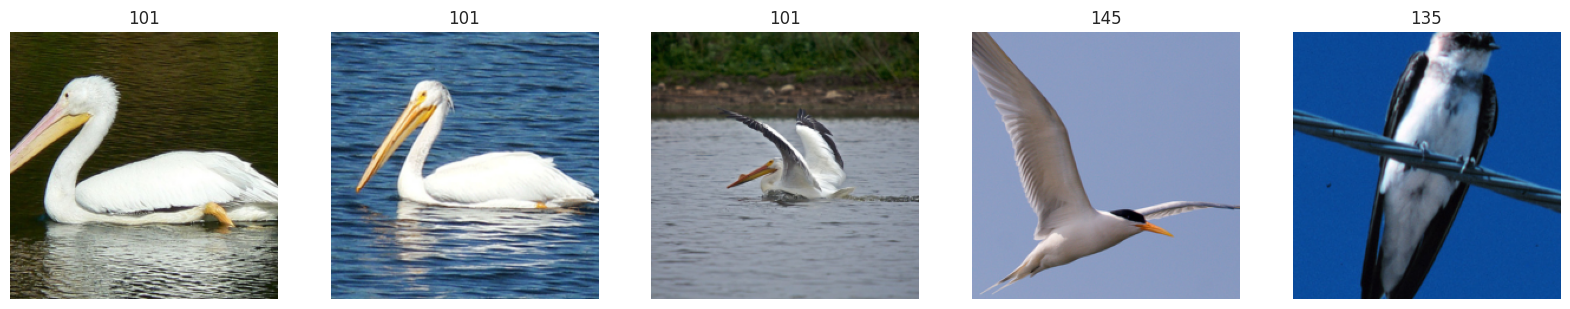

In [13]:
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i, idx in enumerate([qidx, closest_p, furthest_p, closest_n, furthest_n]):
    im, label = data.__getitem__(idx)
    im = inv_normalize(im).numpy().transpose(1, 2, 0)
    ax[i].imshow(im)
    ax[i].axis("off")
    ax[i].set_title(f"{label}")
plt.show()

In [14]:
# compute hessian
from stochman import ContrastiveHessianCalculator, ArccosHessianCalculator
from stochman.utils import convert_to_stochman

hessian_calculators = {
    "contrastive": ContrastiveHessianCalculator,
    "arccos": ArccosHessianCalculator,
}

loss = "contrastive"
loss_approx = "full"

indices_tuples = {"closest_pos_closest_neg" : tuple(([0],[1],[3])),
                  "closest_pos_furthest_neg" : tuple(([0],[1],[4])),
                  "furthest_pos_closest_neg" : tuple(([0],[2],[3])),
                  "furthest_pos_furthest_neg" : tuple(([0],[2],[4]))
                  }

# if arccos, then remove normalization layer from model
if loss == "arccos":
    linear = convert_to_stochman(model.model.linear[:-1])
else:
    linear = convert_to_stochman(model.model.linear)    

hessian_calculator = hessian_calculators[loss](
    wrt="weight", 
    shape="diagonal", 
    speed="half", 
    method=loss_approx
)


# create batch
x_batch = []
for i, idx in enumerate([qidx, closest_p, furthest_p, closest_n, furthest_n]):
    im, label = data.__getitem__(idx)
    x_batch.append(im)
x_batch = torch.stack(x_batch).cuda()

with torch.no_grad():
    x = model.model.backbone(x_batch)
    if hasattr(model.model, "pool"):
        x = model.model.pool(x)


In [17]:
for key in indices_tuples: 
    print(key)
    indices_tuple = indices_tuples[key]
    with torch.no_grad():
        h = hessian_calculator.compute_hessian(x, linear, indices_tuple)

    plt.plot(h.view(-1).cpu().detach().numpy(), label=key)

plt.legend()
plt.show()

closest_pos_closest_neg


In [16]:
for key in indices_tuples: 
    print(key)
    indices_tuple = indices_tuples[key]

    a, p, n = indices_tuple
    ap = an = a

    print(x[ap].shape, x[p].shape, x[n].shape)

closest_pos_closest_neg
torch.Size([1, 2048]) torch.Size([1, 2048]) torch.Size([1, 2048])
closest_pos_furthest_neg
torch.Size([1, 2048]) torch.Size([1, 2048]) torch.Size([1, 2048])
furthest_pos_closest_neg
torch.Size([1, 2048]) torch.Size([1, 2048]) torch.Size([1, 2048])
furthest_pos_furthest_neg
torch.Size([1, 2048]) torch.Size([1, 2048]) torch.Size([1, 2048])
